In [ ]:
!pip install -q tensorflowjs
!nvidia-smi

Sat Jan 15 21:48:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title Runtime
use_tpu = False #@param


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
import urllib
from dataclasses import dataclass
import tensorflowjs as tfjs
import json
np.random.seed(0)

In [ ]:
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-positive.npz",
    "positive.npz",
)
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-negative.npz",
    "negative.npz",
)
with np.load("positive.npz") as r:
    pos_data = r[list(r.keys())[0]]
with np.load("negative.npz") as r:
    neg_data = r[list(r.keys())[0]]

# create labels and stich it all into one
# tensor
labels = np.concatenate(
    (
        np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
        np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
    ),
    axis=0,
)

features = np.concatenate((pos_data, neg_data), axis=0)

In [ ]:
print('Positive data', pos_data.shape[0])
print('Negative data', neg_data.shape[0])

Positive data 1076
Negative data 8240


In [ ]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(vocab_size=21, # include gap
                example_number=len(labels), 
                batch_size=16, 
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.1
               )



In [ ]:
def build_model(L):
    inputs = tf.keras.Input(shape=(L,))

    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)

    counts = tf.keras.layers.GlobalAveragePooling1D()(e)


    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(e)
    x = tf.keras.layers.Concatenate()([x, counts])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=inputs, outputs=yhat, name='sol-rnn')
    return model

def build_infer_model(L):
    inputs = tf.keras.Input(shape=(L,))

    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)

    counts = tf.keras.layers.GlobalAveragePooling1D()(e)


    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(e)
    x = tf.keras.layers.Concatenate()([x, counts])
    x = tf.keras.layers.LayerNormalization()(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu')(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu')(x)
    x = tf.keras.layers.LayerNormalization()(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=yhat, name='sol-rnn-infer')
    return model

In [ ]:
if use_tpu:
  tf.keras.backend.clear_session()

  resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)

  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

  strategy = tf.distribute.experimental.TPUStrategy(resolver)


In [ ]:
# we now need to shuffle before creating TF dataset
# so that our train/test/val splits are random
i = np.arange(len(labels))
np.random.shuffle(i)
labels = labels[i]
features = features[i]
data = tf.data.Dataset.from_tensor_slices((features, labels))
# now split into val, test, train and batch
N = len(data)  
L = None#features[0].shape[-1]
split = int(0.1 * N)
test_data = data.take(split).batch(config.batch_size)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(config.batch_size), \
    nontest.skip(split).shuffle(config.buffer_size).batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
if use_tpu:
  with strategy.scope():
    model = build_model(L)
else:
  model = build_model(L)

  decay_epochs = 50
  decay_steps = N  // config.batch_size * decay_epochs
  lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
      config.lr, decay_steps, alpha=1e-3)
  opt = tf.optimizers.Adam(lr_decayed_fn)
  model.compile(
      opt,
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      steps_per_execution = 60 if use_tpu else None,
      metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)])

In [ ]:
model.summary()

Model: "sol-rnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 32)     672         ['input_1[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 128)         49664       ['embedding[0][0]']              
 )                                                                                                
                                                                                                  
 global_average_pooling1d (Glob  (None, 32)          0           ['embedding[0][0]']        

In [ ]:
result = model.fit(
    train_data, 
    validation_data=val_data, 
    callbacks=[tf.keras.callbacks.LambdaCallback(
        on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
        ),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=10)],
    epochs=150)



lr = 0.001
Epoch 1/150
466/466 [==============================] - 23s 27ms/step - loss: 0.3540 - auc: 0.6140 - binary_accuracy: 0.8836 - val_loss: 0.3924 - val_auc: 0.6572 - val_binary_accuracy: 0.8765
lr = 0.000999368
Epoch 2/150
466/466 [==============================] - 9s 20ms/step - loss: 0.3368 - auc: 0.6801 - binary_accuracy: 0.8846 - val_loss: 0.3454 - val_auc: 0.7209 - val_binary_accuracy: 0.8765
lr = 0.0009974737
Epoch 3/150
466/466 [==============================] - 10s 20ms/step - loss: 0.3270 - auc: 0.7116 - binary_accuracy: 0.8841 - val_loss: 0.3400 - val_auc: 0.7280 - val_binary_accuracy: 0.8754
lr = 0.0009943218
Epoch 4/150
466/466 [==============================] - 9s 20ms/step - loss: 0.3187 - auc: 0.7304 - binary_accuracy: 0.8868 - val_loss: 0.3487 - val_auc: 0.7247 - val_binary_accuracy: 0.8765
lr = 0.0009899203
Epoch 5/150
466/466 [==============================] - 9s 20ms/step - loss: 0.3130 - auc: 0.7488 - binary_accuracy: 0.8873 - val_loss: 0.3474 - val_auc: 0.7

59/59 [==============================] - 1s 9ms/step - loss: 0.2831 - auc: 0.8075 - binary_accuracy: 0.9044


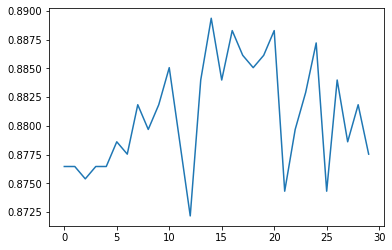

In [ ]:
plt.plot(result.history['val_binary_accuracy'])
test_result = model.evaluate(test_data)
plt.show()

In [ ]:
inference_model = build_infer_model(L)

inference_model.set_weights(model.get_weights())

In [ ]:
inference_model(np.array([1,1,1,1]).reshape(1,-1))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.20612869]], dtype=float32)>

In [ ]:
tfjs.converters.save_keras_model(inference_model, "tfjs_model")

# Model Card

In [ ]:
model_card = {
    'title': 'Hemolytic Prediction',
    'details': 'Recurrent (bi-LSTM) neural network for predicting if a peptide is hemolytic. Developed by Andrew White using data from The Database of Antimicrobial Activity and Structure of Peptides (DBAASP). '
    'The activity cutoff from dose response curves is 25 micrograms / ml. A positive prediction means the peptide is predicted to have hemolytic activity below that cutoff.',
    'use': 'Peptides between 2 and 190 residues. L-chirality and canonical  amino acids',
    'factors': 'Dataset was from sequences thought to be antimicrobial or clinically relevant',
    'metrics': f'Test accuracy {test_result[2]:.2f}. Test AUC {test_result[1]:.2f}',
    'evaluation': 'Withheld positive and negative examples',
    'training': f'{len(pos_data) + len(neg_data)} positive and negative sequences. Only L chirality and canonical amino acids were trained.',
    'caveats': 'The sequences tested were typically from biological sources and were chosen because they are thought to be antimicrobial or biologically active.',
    'ethics': 'These predictions are not a substitute for labratory experiments.'
}
with open('card.json', 'w') as f:
  json.dump(model_card, f)
print(json.dumps(model_card, indent=True))

{
 "title": "Hemolytic Prediction",
 "details": "Recurrent (LSTM) neural network for predicting if a peptide is hemolytic. Developed by Andrew White using data from The Database of Antimicrobial Activity and Structure of Peptides (DBAASP). The activity cutoff from dose response curves is 25 micrograms / ml. A positive prediction means the peptide is predicted to have hemolytic activity below that cutoff.",
 "use": "Peptides between 2 and 190 residues. L-chirality and canonical  amino acids",
 "factors": "Dataset was from sequences thought to be antimicrobial or clinically relevant",
 "metrics": "Test accuracy 0.90. Test AUC 0.81",
 "evaluation": "Withheld positive and negative examples",
 "training": "9316 positive and negative sequences. Only L chirality and canonical amino acids were trained.",
 "caveats": "The sequences tested were typically from biological sources and were chosen because they are thought to be antimicrobial or biologically active.",
 "ethics": "These predictions ar